<img src="causality.jpg" width="300" height="400" align="right"/>

# Time Series Analysis: VAR Models

Author: Christoph Güttner


**Abstract**  
A VAR(1) process is generated, analysed  
(Fourier tranformation, autocorrelation, differenced,   
stationarity, cointegration, Granger causality).   
Daily data of one year (2020) is used to train  
the VAR Model and predict two further months  
(- March 2021). After the residuals are checked,  
forecasts are made and evaluated.

In general, a VAR(p=1) process has the following form:  
    
(1): $z_{t}$ exogenouse Variable  
  
(2): $x_{t}^{{(1)}}=\nu _{1}+a_{{11}}x_{{t-1}}^{{(1)}}+a_{{12}}x_{{t-1}}^{{(2)}}+b_{1}z_{t}+\epsilon _{1}$  
  
(3): $x_{t}^{{(2)}}=\nu _{2}+a_{{21}}x_{{t-1}}^{{(1)}}+a_{{22}}x_{{t-1}}^{{(2)}}+ b_{2}z_{t}+\epsilon _{2}$  

In Matrix representation:

 ${\begin{pmatrix}x^{1}_{t}\\x^{2}_{t}\end{pmatrix}} = {\begin{pmatrix}\nu_{1}\\\nu_{2}\end{pmatrix}} + {\begin{pmatrix}a_{{11}}&a_{{12}}\\a_{{21}}&a_{{22}}\end{pmatrix}} {\begin{pmatrix}x^{1}_{t-1}\\x^{2}_{t-1}\end{pmatrix}} + {\begin{pmatrix}b_{1}\\b_{2}\end{pmatrix} {\begin{pmatrix}z_{1}\\z_{2}\end{pmatrix}}} + {\begin{pmatrix}\epsilon _{1}\\\epsilon _{2}\end{pmatrix}}$  
 
 **Results:** The model captures all information   
 that is in the data and makes appropiate forecasts.



## Table of Contents
* [Loading and Preprocessing](#Loading_and_Preprocessing)
    * [Imports](#Imports)
    * [Functions](#Functions)

* [VAR Process](#Model_Selection)
    * [Generating VAR(1)](#Generating_VAR(1))

* [Explorativ Data Analysis](#Explorative_Data_Analysis)   
    * [Fourier Transformation](#Fourier_Transformation)
    * [(Partial-) Autocorrelation](#Partial_Autocorrelation)
    * [Differencing](#Differencing)
    * [Dickey Fuller Test](#Dickey_Fuller_Test)
    * [Granger Causality Test](#Granger_Causality_Test)

  
* [VAR Model](#VAR_Model)
    * [Train Test Split](#Split)
    * [Model Summary](#Model_Summary)

* [Residuals Check](#VAR_Model)
    * [(Partial-) Autocorrelation](#Partial_Autocorrelation)
    * [Durbin Watson Test](#Durbin_Watson_Test)
      
* [Predictions](#Predictions)
* [Evaluation](#Evaluation)

## Class Imports

In [91]:
import numpy as np
import pandas as pd
from scipy import stats

import sympy as sym
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR

In [92]:
def generate_VAR1(p, A, const, sigma, y, n_samples):
    rv = []
    for t in range(p, n_samples):
        sum = sym.Matrix([[0.0], [0.0]])
        for i in range(1,p+1):
            ynew = A * y
            sum += ynew
            y = ynew
        U = sym.Matrix([[np.random.normal(const, sigma)], [np.random.normal(const, sigma)]])
        rv.append(sum + U)

    return rv

def normalise(data):
    mean=data.mean()
    std = data.std()
    return (data-mean)/ std

def plot_differences(df):
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1)
    fig.tight_layout()
    df.plot(figsize=(15,5), color=['#4E7989', '#FD0C81'], ax=ax1)
    ax1.set_title('Original TS')
    df.diff().plot(figsize=(15,5), color=['#4E7989', '#FD0C81'], ax=ax2)
    ax2.set_title('First Difference')
    df.diff().diff().plot(figsize=(15,5), color=['#4E7989', '#FD0C81'], ax=ax3)
    ax3.set_title('Second Difference')
    plt.show()


def dickey_fuller(ts):
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

def test_cointegration(ts1, ts2):
    result = coint(ts1, ts2)
    print('t-statistic of unit-root test on residuals: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    list=['1%','5%','10%']
    for i,value in enumerate(result[2]):
        
        print('\t%s: %.3f' % (list[i],value))

    if result[0] < result[2][1]:
        print ("Reject Ho - Time Series are Cointegrated")
    else:
        print ("Failed to Reject Ho - Time Series are Not Cointegrated")


def rolling_forecast_VAR(df,lag_order, train_len, test_len):
    #start = df.iloc[train_len, :].values
    rolling_predictions = []
    for i in range(test_len):
        train = df.iloc[:(train_len-1+i), :]
        model = VAR(train)
        model_fit = model.fit(maxlags=lag_order)                     
        pred = model_fit.forecast(train.values[:], steps=1)
        rolling_predictions.append(pred)
    return rolling_predictions

## VAR(1) Process

Here, we generate a simple VAR(1) of the following form:

 ${\begin{pmatrix}x^{1}_{t}\\x^{2}_{t}\end{pmatrix}} = {\begin{pmatrix}a_{{11}}&a_{{12}}\\a_{{21}}&a_{{22}}\end{pmatrix}}{\begin{pmatrix}x^{1}_{t-1}\\x^{2}_{t-1}\end{pmatrix}}+ {\begin{pmatrix}\epsilon _{1}\\\epsilon _{2}\end{pmatrix}}$ 

In [93]:

t1 = sym.symbols('t-1')
t2 = sym.symbols('t-2')
a11, a12, a13, a14  = sym.symbols('a11 a12 a13 a14')
x1 = sym.IndexedBase('x1')
x2 = sym.IndexedBase('x2')
epsilon, epsilon  = sym.symbols('epsilon epsilon')


M1 = sym.Matrix([[a11, a12], [a13, a14]])
M2 = sym.Matrix([x1[t1], x2[t1]])

M3 = sym.Matrix([epsilon, epsilon])



M1*M2 + M3


Matrix([
[a11*x1[t-1] + a12*x2[t-1] + epsilon],
[a13*x1[t-1] + a14*x2[t-1] + epsilon]])

### More concrete

Our Var(1)process has the following  parameter matrix 

$A_{t} = {\begin{pmatrix}a_{{11}}&a_{{12}}\\a_{{21}}&a_{{22}}\end{pmatrix}}= {\begin{pmatrix}1 &0,1\\-0,1& 1\end{pmatrix}}$

If the the sum of parameters is equal to 1, we say there exists a unit root in the time series.

## Data Generating

In [94]:
date_index = pd.date_range(start='1/1/2020', end='3/1/2021')
A1 = sym.Matrix(np.array([[1, 0.1], [-0.1, 1]]))
p = 1
sigma = 0.01
const=0.0

U = sym.Matrix([[np.random.normal(0.0, sigma)], [np.random.normal(0.0, sigma)]])
y = sym.Matrix([[0.7], [-0.7]])


vector_ar = generate_VAR1(p, A1, const, sigma, y, len(date_index))


In [95]:
V1=[]
V2=[]
for i in range(len(vector_ar)):
    V1.append(np.float32(vector_ar[i][0]))
    V2.append(np.float32(vector_ar[i][1]))

dict= {'V1': V1, 'V2':V2}
df=pd.DataFrame(dict, index=date_index[p:])
df.head(2)

,V1,V2
2020-01-02,0.612874,-0.768505
2020-01-03,0.543191,-0.858819




### Normalise 

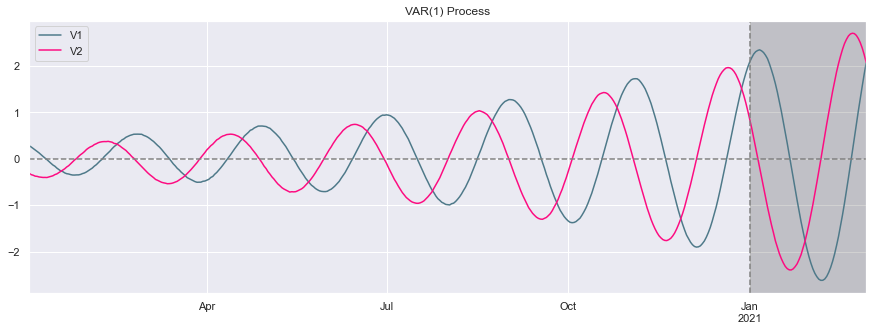

In [96]:
df = normalise(df)

df .plot(figsize=(15,5), color=['#4E7989', '#FD0C81'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.title('VAR(1) Process')
plt.show()

## Explorativ Data Analysis

### Check Frequency

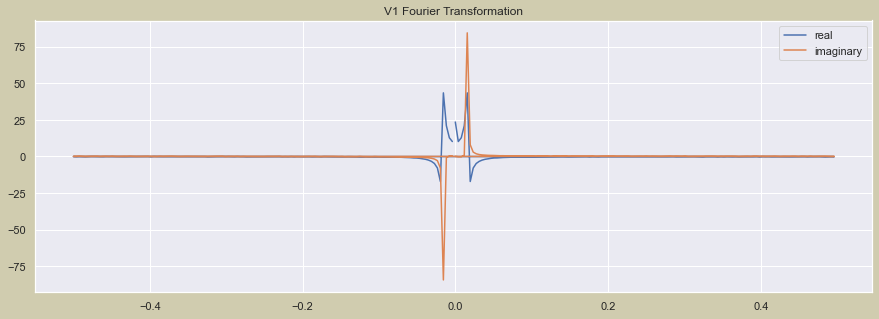

In [97]:
freq = np.fft.fftfreq(df['V1'].index[:256].shape[-1]) #256=2**6
sp = np.fft.fft(df['V1'][:256])

plt.figure(facecolor='#D0CCAF', figsize=(15,5))
plt.plot(freq, sp.real,label='real')
plt.plot(freq, sp.imag, label='imaginary')
plt.title('V1 Fourier Transformation')
plt.legend()
plt.show()

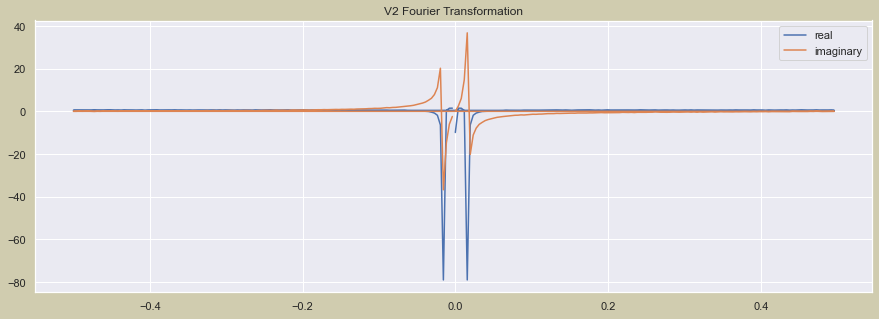

In [98]:
freq = np.fft.fftfreq(df['V2'].index[:256].shape[-1]) #256=2**6
sp = np.fft.fft(df['V2'][:256])

plt.figure(facecolor='#D0CCAF', figsize=(15,5))
plt.plot(freq, sp.real,label='real')
plt.plot(freq, sp.imag, label='imaginary')
plt.title('V2 Fourier Transformation')
plt.legend()
plt.show()

## Check Partial_Autocorrelation

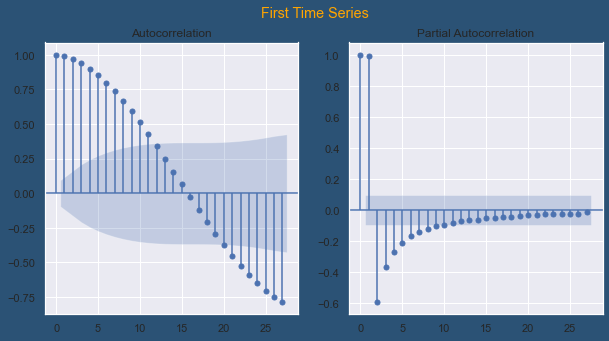

In [99]:
fig = plt.figure(figsize=(10,5),facecolor='#2B5275')
fig.suptitle('First Time Series', color ='orange')
ax = fig.add_subplot(1,2,1)
plot_acf(df['V1'], ax=ax)
ax = fig.add_subplot(1,2,2)
plot_pacf(df['V1'], ax=ax)
plt.show()

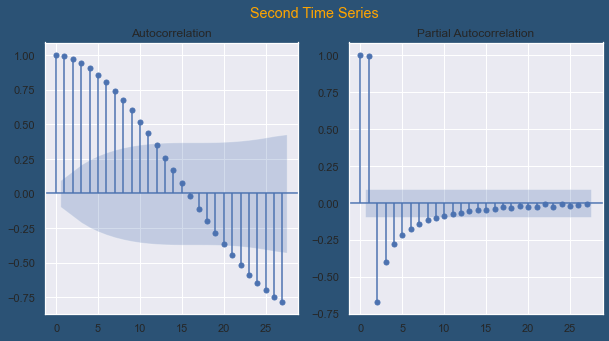

In [100]:
fig = plt.figure(figsize=(10,5),facecolor='#2B5275')
fig.suptitle('Second Time Series', color ='orange')
ax = fig.add_subplot(1,2,1)
plot_acf(df['V2'], ax=ax)
ax = fig.add_subplot(1,2,2)
plot_pacf(df['V2'], ax=ax)
plt.show()

## Check Differencing

**Result:** Differencing here does not really help to remove increasing heteroscedasticity

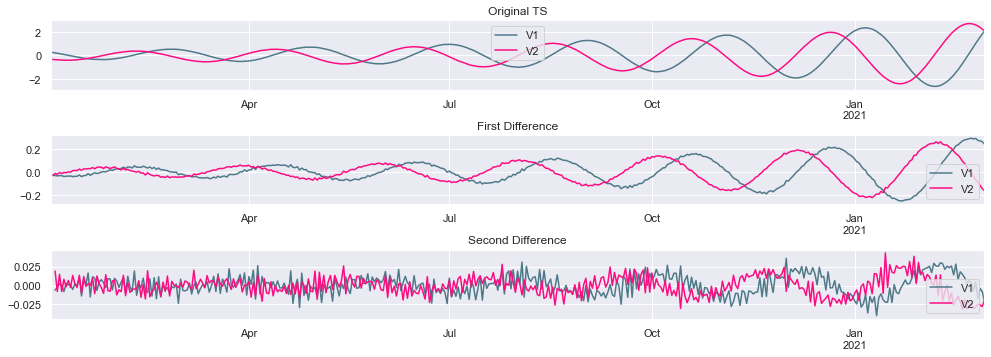

In [101]:
plot_differences(df)

## Dickey_Fuller_Test

Testing Time Series for stationarity 

**Result:** The Dickey Fuller Test considers both time series to be stationary,  
although they have a unit root as well as obviouse increasing heteroscedasticity

In [102]:
dickey_fuller(df['V1'])

ADF Statistic: -11.360282
p-value: 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Reject Ho - Time Series is Stationary


In [103]:
dickey_fuller(df['V2'])

ADF Statistic: -11.906977
p-value: 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Reject Ho - Time Series is Stationary


## Check Cointegration

In [104]:
test_cointegration(df['V1'], df['V2'])

t-statistic of unit-root test on residuals: -0.766552
p-value: 0.938960
Critical Values:
	1%: -3.922
	5%: -3.351
	10%: -3.054
Failed to Reject Ho - Time Series are Not Cointegrated


## Granger Causality test

**Results** Time Series Granger cause each other significantly starting from the first lag



In [105]:
test_result = grangercausalitytests(df[['V1', 'V2']], 2)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=180364.4349, p=0.0000  , df_denom=421, df_num=1
ssr based chi2 test:   chi2=181649.6921, p=0.0000  , df=1
likelihood ratio test: chi2=2570.4717, p=0.0000  , df=1
parameter F test:         F=180364.4349, p=0.0000  , df_denom=421, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=659.2214, p=0.0000  , df_denom=418, df_num=2
ssr based chi2 test:   chi2=1334.2136, p=0.0000  , df=2
likelihood ratio test: chi2=602.3996, p=0.0000  , df=2
parameter F test:         F=659.2214, p=0.0000  , df_denom=418, df_num=2


In [106]:
test_result = grangercausalitytests(df[['V2', 'V1']], 2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=157615.6520, p=0.0000  , df_denom=421, df_num=1
ssr based chi2 test:   chi2=158738.8039, p=0.0000  , df=1
likelihood ratio test: chi2=2513.4506, p=0.0000  , df=1
parameter F test:         F=157615.6520, p=0.0000  , df_denom=421, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=648.5553, p=0.0000  , df_denom=418, df_num=2
ssr based chi2 test:   chi2=1312.6263, p=0.0000  , df=2
likelihood ratio test: chi2=597.1709, p=0.0000  , df=2
parameter F test:         F=648.5553, p=0.0000  , df_denom=418, df_num=2


## Model Building

### Train Test Split

In [107]:
df_train = df['1/1/2020':'1/1/2021']
df_test  =  df['1/1/2021':'3/1/2021']

In [108]:
train_len = len(df_train)
test_len = len(df_test)

train_len, test_len

(366, 60)

### Getting lag order

**Results:** BIC suggest lag order 7

In [109]:
model = VAR(df_train)
lag_orders = model.select_order(10)
lag_orders.summary()

,AIC,BIC,FPE,HQIC
0,-0.8450,-0.8232,0.4296,-0.8364
1,-21.14,-21.07,6.600e-10,-21.11
2,-21.70,-21.59,3.757e-10,-21.66
3,-21.97,-21.81,2.887e-10,-21.90
4,-22.15,-21.95,2.410e-10,-22.07
5,-22.20,-21.96,2.277e-10,-22.11
6,-22.22,-21.93,2.248e-10,-22.10
7,-22.30*,-21.98*,2.060e-10*,-22.17*
8,-22.29,-21.92,2.079e-10,-22.15
9,-22.29,-21.88,2.082e-10,-22.13


In [122]:
lag_order = 7
model_fit = model.fit(maxlags=lag_order)
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Mar, 2021
Time:                     23:43:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -21.9617
Nobs:                     359.000    HQIC:                  -22.1571
Log likelihood:           3011.57    FPE:                2.09547e-10
AIC:                     -22.2862    Det(Omega_mle):     1.93076e-10
--------------------------------------------------------------------
Results for equation V1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.024902         0.002109           11.810           0.000
L1.V1         0.086942         0.052083            1.669           0.095
L1.V2         0.005269         0.056459            0.093           0.926
L2.V1         0.142220

## Check Residuals

**Results:** The residuals have no autocorrelation, hence the model seems to capture all information.

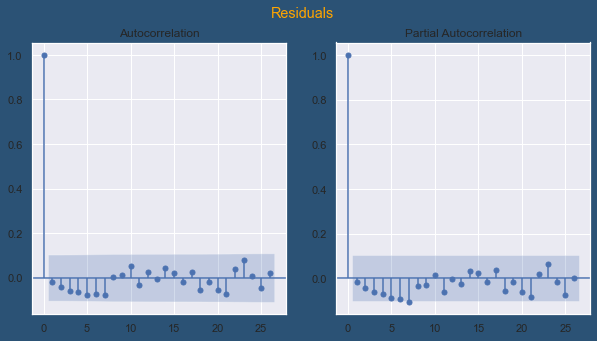

In [123]:
fig = plt.figure(figsize=(10,5),facecolor='#2B5275')
fig.suptitle('Residuals', color ='orange')
ax = fig.add_subplot(1,2,1)
plot_acf(model_fit.resid['V1'], ax=ax)
ax = fig.add_subplot(1,2,2)
plot_pacf(model_fit.resid['V1'], ax=ax)
plt.show()

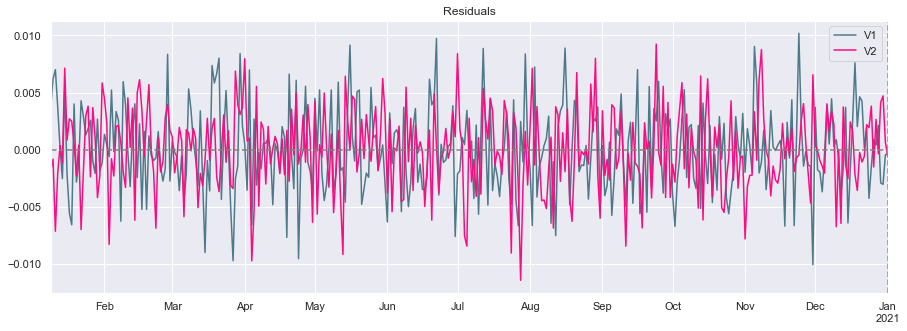

In [124]:
model_fit.resid.plot(figsize=(15,5), color=['#4E7989', '#FD0C81'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.title('Residuals')
plt.show()

## Durbin-Watson Statistic
We will now check again whether there is any correlation left in the residuals and if so, we will have to increase the order of our model. Values of this statistic varies between 0 & 4. Values closer to 2 mean that there is no significant serial correlation. Values close to 4 indicate strong negative correlation while those closer to 0 imply strong positive correlation.

In [125]:
dw_r = durbin_watson(model_fit.resid)

for col, val in zip(df.columns, dw_r):
    print(col, ':', round(val, 2))

V1 : 2.04
V2 : 2.01


## Forecasts

### Forecast(60 timesteps)

In [126]:
horizon=len(df_test)
prediction = model_fit.forecast(df.values[:train_len-1,:], steps=horizon)


df_pred = pd.DataFrame(prediction, columns=["V1_forecast", "V2_forecast"], index=df_test.index)
df_prediction =pd.concat([df, df_pred], axis=1)
df_prediction.tail()

,V1,V2,V1_forecast,V2_forecast
2021-02-25,1.024607,2.591127,1.021089,2.597406
2021-02-26,1.297551,2.500196,1.299358,2.505736
2021-02-27,1.566628,2.383666,1.567966,2.387645
2021-02-28,1.827700,2.239350,1.824130,2.244050
2021-03-01,2.067319,2.076237,2.065163,2.076131


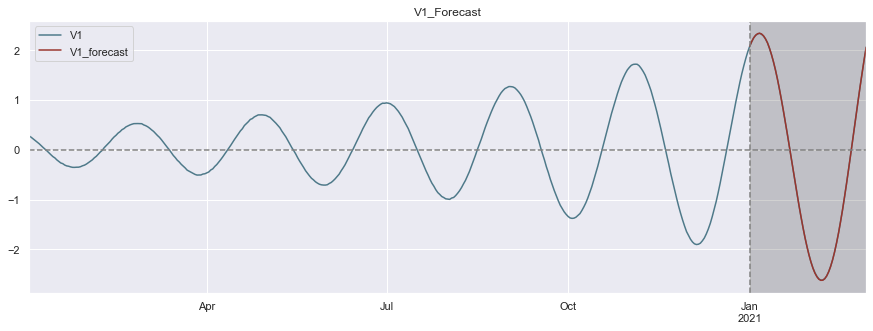

In [127]:
df_prediction[['V1','V1_forecast']].plot(figsize=(15,5), color=['#4E7989', '#9A352D'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.title('V1_Forecast')
plt.show()

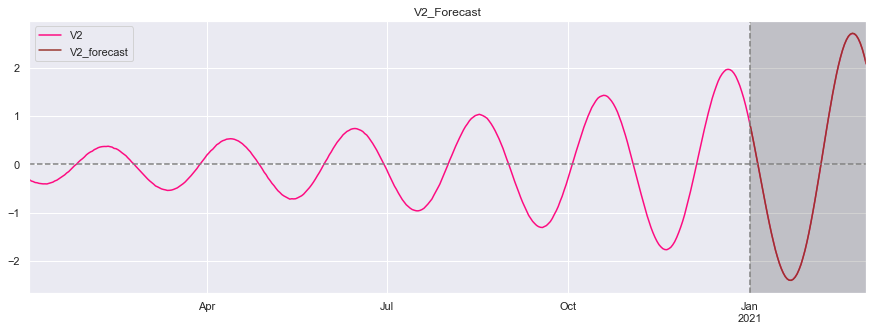

In [128]:
df_prediction[['V2','V2_forecast']].plot(figsize=(15,5), color=['#FD0C81', '#9A352D'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.title('V2_Forecast')
plt.show()

### Rolling Forecast(1 timestep ahead)

In [129]:
rolling_forecast = rolling_forecast_VAR(df,lag_order, train_len, test_len)



In [130]:
rf_V1=[]
rf_V2=[]
for i in range(0,len(rolling_forecast)):
    for j in range(2):
        rf=rolling_forecast[i][0][j]
        if j == 0:
            rf_V1.append(rf)
        else:
            rf_V2.append(rf)

In [131]:
rf = {'V1_Rolling Forecast':rf_V1, 'V2_Rolling Forecast':rf_V2}
df_rf = pd.DataFrame(rf, index=df_test.index)
df_horizon =pd.concat([df, df_rf], axis=1)
df_horizon.tail()

,V1,V2,V1_Rolling Forecast,V2_Rolling Forecast
2021-02-25,1.024607,2.591127,1.020538,2.594179
2021-02-26,1.297551,2.500196,1.298388,2.500964
2021-02-27,1.566628,2.383666,1.567182,2.383115
2021-02-28,1.827700,2.239350,1.822473,2.239212
2021-03-01,2.067319,2.076237,2.063653,2.070772


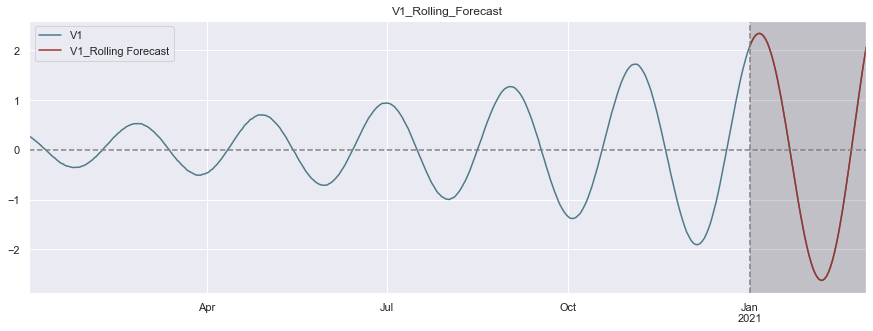

In [132]:
df_horizon[['V1','V1_Rolling Forecast']].plot(figsize=(15,5), color=['#4E7989', '#9A352D'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.title('V1_Rolling_Forecast')
plt.show()

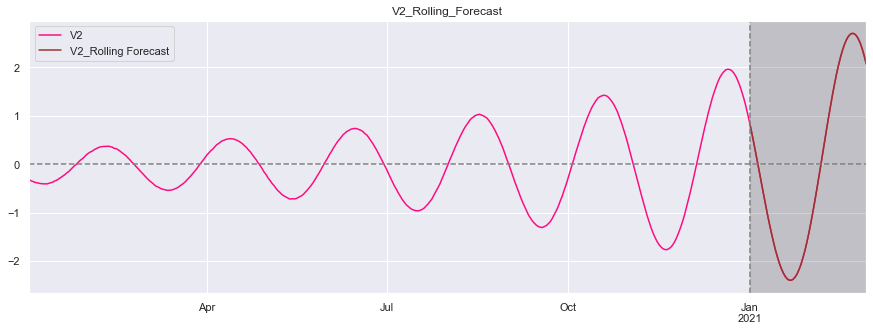

In [134]:
df_horizon[['V2','V2_Rolling Forecast']].plot(figsize=(15,5), color=['#FD0C81', '#9A352D'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.title('V2_Rolling_Forecast')
plt.show()

## Evaluation

### Evaluating Forecast(60 timesteps)

In [135]:
# Extract the predicted and true values of our time series
true = df_test['V1'].values
model_performance = df_prediction['V1_forecast']['1/1/2021':]


# Compute the mean square error
mse = ((model_performance - true) ** 2).mean()
print('The Mean Squared Error of the V1 prediction is {}'.format(round(mse, 2)))

The Mean Squared Error of the V1 prediction is 0.0


In [136]:
true = df_test['V2'].values
model_performance = df_prediction['V2_forecast']['1/1/2021':]


# Compute the mean square error
mse = ((model_performance - true) ** 2).mean()
print('The Mean Squared Error of the V2 prediction is {}'.format(round(mse, 2)))

The Mean Squared Error of the V2 prediction is 0.0


### Evaluating Rolling Forecast(1 timestep)

In [138]:
true = df_test['V1'].values
model_performance = df_horizon['V1_Rolling Forecast']['1/1/2021':]


# Compute the mean square error
mse = ((model_performance - true) ** 2).mean()
print('The Mean Squared Error of the V1 rolling forecast is {}'.format(round(mse, 2)))

The Mean Squared Error of the V1 rolling forecast is 0.0


In [139]:
true = df_test['V2'].values
model_performance = df_horizon['V2_Rolling Forecast']['1/1/2021':]


# Compute the mean square error
mse = ((model_performance - true) ** 2).mean()
print('The Mean Squared Error of the V2 rolling forecast is {}'.format(round(mse, 2)))

The Mean Squared Error of the V2 rolling forecast is 0.0
